<a href="https://colab.research.google.com/github/shivani-bhardwaj/Social-Distancing-Tool/blob/master/unedited_Social_Distancing_Tool(ML_%26_Deep_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project topic : Building a social distancing tool**# 

This is an interesting model that can potentially detect the real-time location of an individual, and return a warning if the distance between two people is dangerously close. As we know during this current epidemic, social distancing has emerged an effective and important solution in keeping people safe and contolling the spread of this deadly disease.

Not only that, the WHO itself has advised each and every notion to adopt the policy of Social Distancing to control the spread of this deadly pathogen at least until a vaccine has been found.


For this , we'll be using the concept of ***Object Detection*** and a open-source library for the same purpose known as ***Detectron-2***.

#**Step 1 : Installing dependencies**#



In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# opencv is pre-installed on colab
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=06c286a33cfca4e7303d2507a1eeb763f63baa4eb208aed91c686ed5c1c9b8ab
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4ianlhq5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4ianlhq5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

#**Step 1(b) : Importing libraries**#

In [ ]:
#Setting detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

#importing common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

#importing common detectron2 utilities 
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

#**Step 2 : Importing the input video from google drive**#

First of all, we'll mount the Google Drive to the Google Colaboratory and then read the video frame by frame for the purpose of object detection.



In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')
%cd /GDrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/GDrive
[Errno 2] No such file or directory: '/GDrive'
/content


In [ ]:
%%time
!mkdir frames/

!rm -r frames/*


#specify path to video
video = "GDrive/My Drive/videoplayback.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

mkdir: cannot create directory ‘frames/’: File exists
rm: cannot remove 'frames/*': No such file or directory
CPU times: user 9.31 s, sys: 443 ms, total: 9.75 s
Wall time: 14.2 s


#**Step 2(b) : Checking frame rate of the video**#


In [ ]:
FPS = cap.get(cv2.CAP_PROP_FPS)
print(FPS)

24.0


#**Step 3 : Download the pre-trained model for object detection**#

Download the pre-trained model from Detectron 2's model zoo and the model is ready for inference 

In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:06, 21.5MB/s]                           


#**Step 3(b) : Reading the image and passing to model for prediction**#

In [ ]:
#read an image
img = cv2.imread("frames/230.png")

#pass to the model
outputs = predictor(img)

#**Step 4 : Drawing the prediction on the image**#

We can Visualize to draw the predictions on the image.

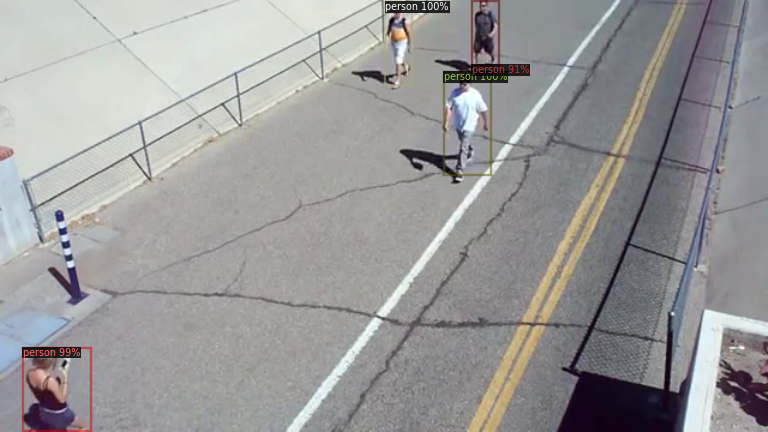

In [ ]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

#**Step 4(b) : Understanding the objects present in an image**#



In [ ]:
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[0 0 0 0]


#**Step 4(c) : These are the bounding boxes of an object**#

In [ ]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[370.1335    60.960667 408.9634   146.07251 ]
 [321.1411     2.771792 343.6942    71.781784]
 [ 19.052113 289.90448   75.66216  359.3432  ]
 [393.33368    2.129035 415.5884    55.12557 ]]


**Since,there are different object in the image, let's identify classes and bounding boxes related to only the people :**

In [ ]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

**Understanding the format of the bounding box :**

In [ ]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

370.1335 60.960667 408.9634 146.07251


**Draw a bounding box for one of the people :**

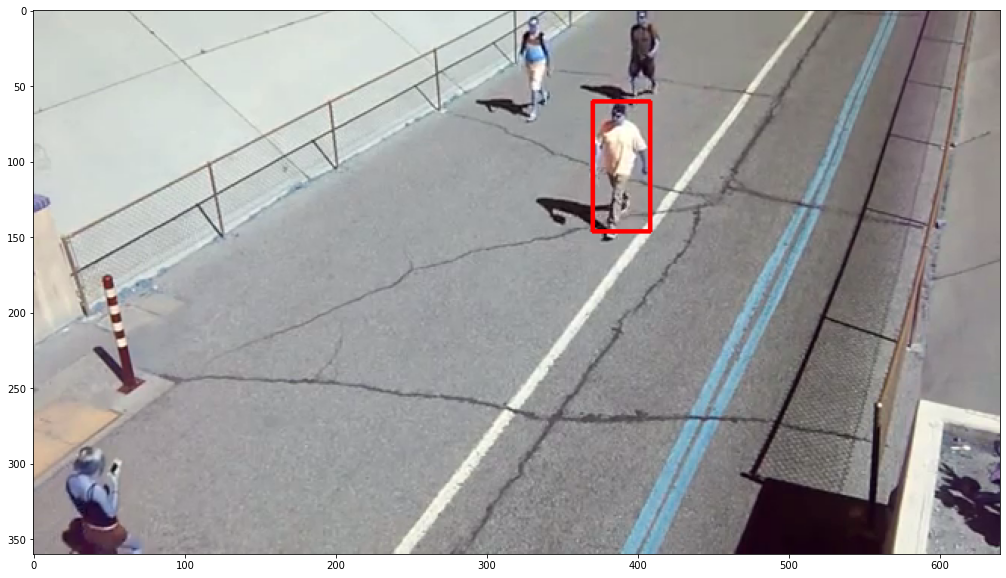

In [ ]:
img = cv2.imread('frames/230.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

#**Step 5 : Identifying the safe and appropriate distance among the people in the set of frames**#

Once we know the bounding boxes for each person, we can identify and compute the distance between two people.

Here, we have chosen the bottom centre of the rectangle for representing each person to measure the distance accurately. 

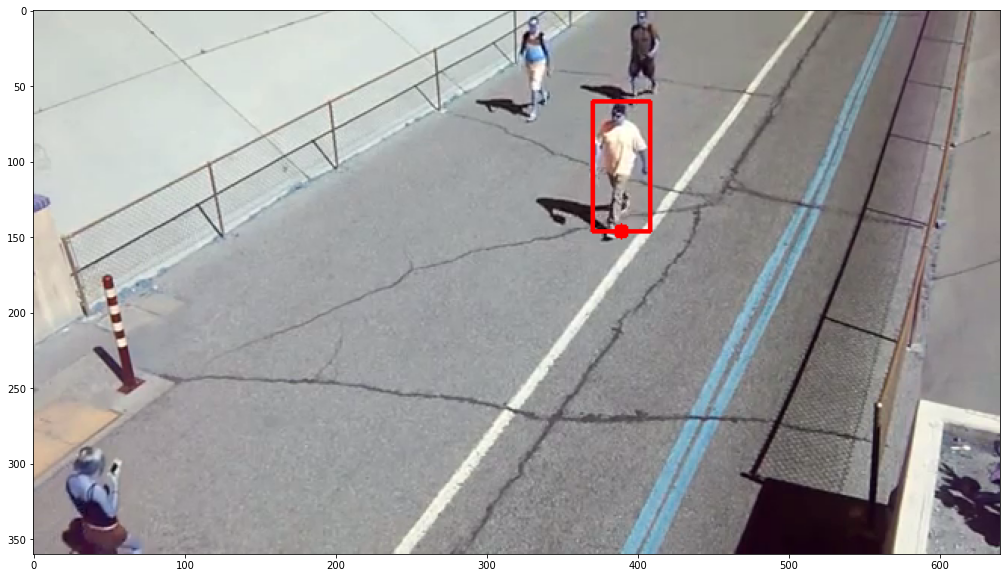

In [ ]:
#compute center 
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

**A function that returns the bottom center of every bounding box :**

In [ ]:
#define a function which return the bottom center of every bbox
def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

**Drawing points for every bounding box on the image :**

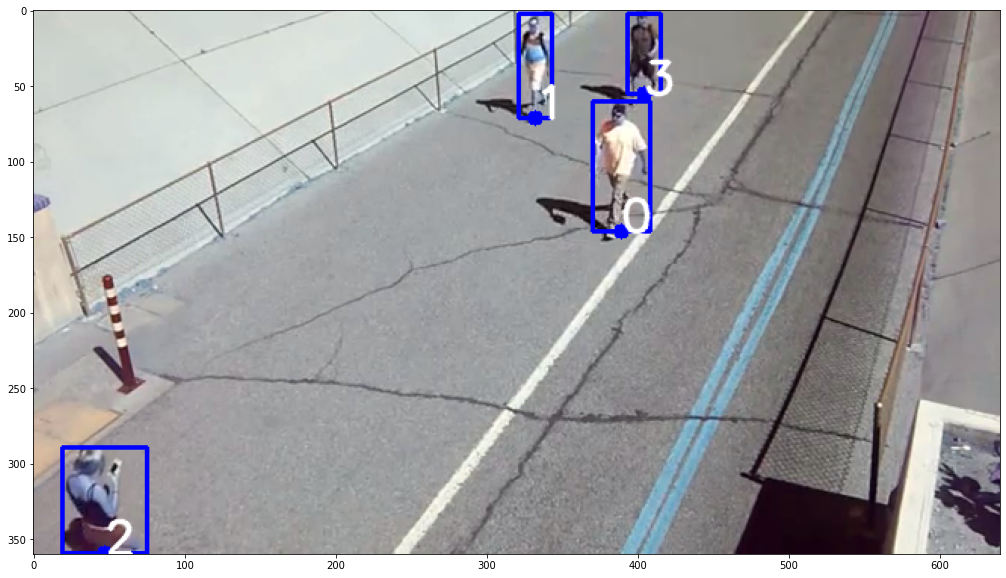

In [ ]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

#**Step 5(b) : Defining a function to compute the Eucleadean distance between two points or boxes in an image :**#

In [ ]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 69.5 ms, sys: 12.8 ms, total: 82.2 ms
Wall time: 86.1 ms


**Computing the distance between every pair of points :**

In [ ]:
dist= compute_distance(midpoints,num)

**Defining a function that returns closest people on given proximity distance. Here, proximity distance refers to minimum distance between two people :**


In [ ]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.6 µs


**Setting up a threshold for the proximity distance (say 100) :**

In [ ]:
import pandas as pd

thresh=20
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

,p1,p2,dist


**Defining a function to change the color of closest people to red :**

In [ ]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

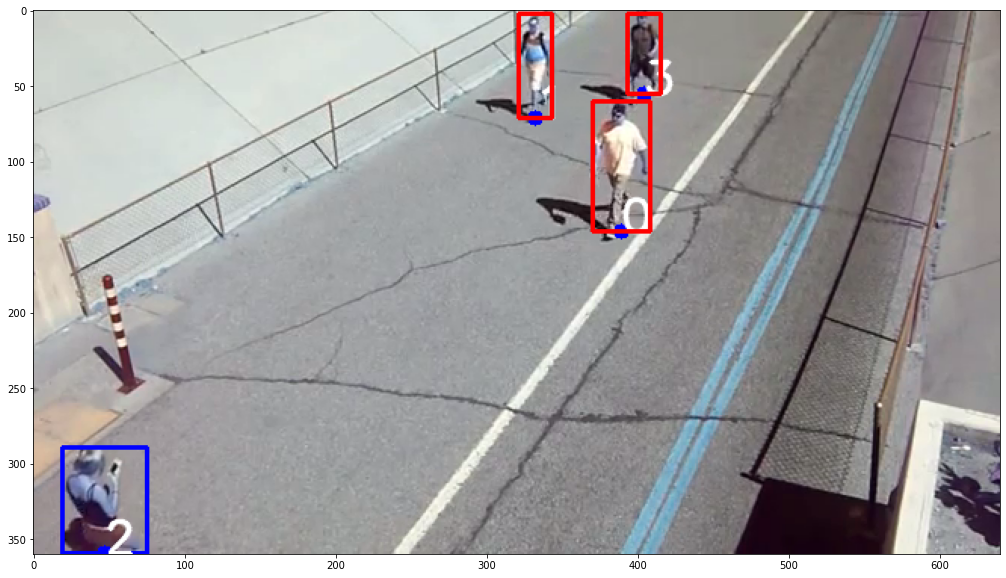

In [ ]:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

#**Final Step : Carrying out the similar set of steps on every frame of the video**#

In [ ]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

**Function that will cover all the steps we covered on each and every frame of the video :**

In [ ]:
def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames/'+name,img)
  return 0

**Identifying the closest people and changing the color to red :**

In [ ]:
from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

**Putting it all together in each and every frame of the video :**

In [ ]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):

  #reading each files
  img = cv2.imread('frames/'+frames[i])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  height, width, layers = img.shape
  size = (width,height)
  
  #inserting the frames into image array
  frame_array.append(img)
                     
out = cv2.VideoWriter('sampleOutput.mp4',cv2.VideoWriter_fourcc(*'DIVX'),25,size)

for i in range(len(frame_array)):
  out.write(frame_array[i])
out.release()  